# Чат-бот

### Описание:

#### В боте реализовано распознавание четырех интентов:

1. Бот сообщает текущее время.

2. На базе файла ответот от майл.ру ведет беседу.

3. На основе заданных ему продуктов может сгенерировать рецепт.

4. На "спасибо" бот отвечает: "Не стоит меня благодарить. Рад был Вам помочь!"

Датасеты "Otvety.txt" и "all_recepies_inter.csv" взяты из открытых источников.

## Установка библиотек и подготовка данных.

In [1]:
!pip install python-telegram-bot --upgrade #restart needed

In [2]:
!pip install pymorphy2

In [3]:
!pip install pymorphy2 stop_words annoy

In [48]:
import os
import numpy as np
import pandas as pd

import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
import annoy
from gensim.models import Word2Vec, FastText
from tqdm import tqdm_notebook
import pickle
from catboost import CatBoostClassifier

from telegram.ext  import Updater, CommandHandler, MessageHandler, Filters

In [2]:
# !wget 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1NajRMVZhXm9FXaEnh4IbXcWmK1fEo_9j' -O data.zip

--2022-12-20 17:29:48--  https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1NajRMVZhXm9FXaEnh4IbXcWmK1fEo_9j
Распознаётся drive.google.com (drive.google.com)… 173.194.222.194, 2a00:1450:4010:c0b::c2
Подключение к drive.google.com (drive.google.com)|173.194.222.194|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://doc-0k-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eu1us9u042mv0f67bh7dulq711c0sn0t/1671546525000/06840004559052771215/*/1NajRMVZhXm9FXaEnh4IbXcWmK1fEo_9j?e=download&uuid=5884b4df-6cbd-48d6-80ed-c79f802e8bfd [переход]
Предупреждение: в HTTP маски не поддерживаются.
--2022-12-20 17:29:49--  https://doc-0k-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eu1us9u042mv0f67bh7dulq711c0sn0t/1671546525000/06840004559052771215/*/1NajRMVZhXm9FXaEnh4IbXcWmK1fEo_9j?e=download&uuid=5884b4df-6cbd-48d6-80ed-c79f802e8bfd
Распознаётся doc-0k-18-docs.googleuserconte

In [4]:
# !unzip data.zip

Archive:  data.zip
replace Otvety.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
%%time

assert True

question = None
written = False

with open("prepared_answers.txt", "w") as fout:
    with open("./Otvety.txt", "r") as fin:
        for line in tqdm_notebook(fin):
            if line.startswith("---"):
                written = False
                continue
            if not written and question is not None:
                fout.write(question.replace("\t", " ").strip() + "\t" + line.replace("\t", " "))
                written = True
                question = None
                continue
            if not written:
                question = line.strip()
                continue

<timed exec>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

CPU times: user 12.7 s, sys: 1.79 s, total: 14.5 s
Wall time: 27.5 s


In [3]:
morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)

In [4]:
def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [5]:
def preprocess_txt1(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i != ""]
    return spls

In [8]:
assert True

sentences = []

morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)
c = 0

with open("./Otvety.txt", "r") as fin:
    for line in tqdm_notebook(fin):
        spls = preprocess_txt(line)
        sentences.append(spls)
        c += 1
        if c > 500000:
            break

/var/folders/r4/tj59nbc57_3bl6zqxrkxfk140000gn/T/ipykernel_806/3175338086.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

In [10]:
import pickle
with open('./sent.pkl', 'wb') as f:
   pickle.dump(sentences, f)

In [9]:
with open('./sent.pkl', 'rb') as f:
  sentences = pickle.load(f)

In [10]:
print(len(sentences))
sentences[100]

500001


['приказ',
 'командировка',
 'храниться',
 'вместе',
 'приказ',
 'предоставление',
 'отпуск',
 'наложение',
 'взыскание',
 'командировочный',
 'удостоверение',
 'храниться',
 'бухгалтерия',
 'авансовый',
 'отчёт']

In [11]:
sentences = [i for i in sentences if len(i) > 2]

In [14]:
print('start train fasttext')
modelFT = FastText(sentences=sentences, min_count=1, window=5, workers=4)
modelFT.save("ft_model")

start train fasttext


In [15]:
modelFT.save("./ft_model")

In [12]:
modelFT = FastText.load("ft_model")

In [17]:
ft_index = annoy.AnnoyIndex(100 ,'angular')

index_map = {}
counter = 0

with open("prepared_answers.txt", "r") as f:
    for line in tqdm_notebook(f):
        n_ft = 0
        spls = line.split("\t")
        index_map[counter] = spls[1]
        question = preprocess_txt(spls[0])
        vector_ft = np.zeros(100)
        for word in question:
            if word in modelFT.wv:
                vector_ft += modelFT.wv[word]
                n_ft += 1
        if n_ft > 0:
            vector_ft = vector_ft / n_ft
        ft_index.add_item(counter, vector_ft)
            
        counter += 1

ft_index.build(10)
ft_index.save('speaker.ann')

/var/folders/r4/tj59nbc57_3bl6zqxrkxfk140000gn/T/ipykernel_4157/3382554697.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(f):


0it [00:00, ?it/s]

True

In [18]:
ft_index.save('./speaker.ann')

True

In [35]:
with open('index_map.pkl', 'wb') as fp:
   pickle.dump(index_map, fp)

In [13]:
with open('index_map.pkl', 'rb') as f:
  index_map = pickle.load(f)

In [14]:
ft_index = annoy.AnnoyIndex(100, 'angular')
ft_index.load('speaker.ann') 

True

In [15]:
ft_index.get_nns_by_vector(np.zeros(100), 2)

[6593, 28065]

## Загрузка данных - рецепты


In [16]:
path_recipes = './'

In [17]:
df_recipes = pd.read_csv('all_recepies_inter.csv', sep='\t')

In [18]:
df_recipes.head()

Unnamed: 0                                               name  \
0           0  рассольник классический с перловкой и солеными...   
1           1                    Суп пюре из белокочаной капусты   
2           2                     Постные щи из квашеной капусты   
3           3                  Тюря- простой суп быстро и вкусно   
4           4                    Фасолевый суп из красной фасоли   

                                         composition         cooking_type  \
0  [{'Перловка': 0.1, 'unit': 'стак. (200 мл)'}, ...          варка,жарка   
1  [{'Капуста белокочанная': 50.0, 'unit': 'гр'},...                варка   
2  [{'Капуста квашеная': 116.7, 'unit': 'гр'}, {'...  варка,жарка,тушение   
3  [{'Квас': 0.2, 'unit': 'л'}, {'Лук репчатый': ...                сырое   
4  [{'Вода': 0.3, 'unit': 'л'}, {'Картошка': 0.3,...                варка   

                                          Инструкции dish_type        Дата  \
0  Подготовить указанные ингредиенты для приготов...    первое  05.06.2015   
1  Необходимые ингредиенты\r\nНарезаем лук, морко...    первое  27.06.2015   
2  Честно признаюсь, у меня не было репы на момен...    первое  12.02.2013   
3  \r\nНачинаем мы приготовление тюри с того, что...    первое  02.03.2011   
4  Подготовить ингредиенты. Для приготовления суп...    первое  28.01.2013   

                  photo                                             source  \
0  photo_1000menu_1.jpg  https://1000.menu/cooking/33395-rassolnik-s-pe...   
1  photo_1000menu_2.jpg  https://1000.menu/cooking/25399-sup-pure-iz-be...   
2  photo_1000menu_3.jpg       https://1000.menu/cooking/5159-postnje-shchi   
3  photo_1000menu_4.jpg               https://1000.menu/cooking/5085-turya   
4  photo_1000menu_5.jpg  https://1000.menu/cooking/38765-fasolevyi-sup-...   

                                   composition_inter  
0  [{'product_id': 4253, 'name_source': 'Перловая...  
1  [{'product_id': 2286, 'name_source': 'Капуста ...  
2  [{'product_id': 0, 'name_source': 'Капуста ква...  
3  [{'product_id': 0, 'name_source': 'Квас', 'uni...  
4  [{'product_id': 828, 'name_source': 'Вода', 'u...

In [19]:
df_recipes.shape

(27884, 10)

In [20]:
data = df_recipes['Инструкции']

In [21]:
import re
from sklearn.model_selection import train_test_split

def build_text_files(data_json, dest_path):
    f = open(dest_path, 'w')
    data = ''
    for texts in data_json:
        summary = str(texts).strip()
        summary = re.sub(r"\s", " ", summary)
        data += summary + "  "
    f.write(data)

In [22]:
data.shape

(27884,)

In [23]:
data[10]

'Приготовим ингредиенты по списку. Поскольку мы используем свежую капусту, а не квашенную, то должен быть какой-то продукт, который создаст кислый вкус, отличающий его от других супов. Это могут быть антоновские яблоки, щавель или соленые грибы. Я использовала последний из них.\r\nМорковь моем, чистим и натираем на средней терке.\r\nРепчатый лук чистим от шелухи и мелко нарезаем ножом.\r\nБелокочанную капусту очищаем от верхних сухих листьев и мелко шинкуем ножом.\r\nКартофель моем, чистим и нарезаем небольшими кубиками или соломкой, снова промываем, чтобы удалить крахмал и сделать бульон прозрачным. Картофель сделает суп гуще и сытнее.\r\nГрибы можно использовать любые: шампиньоны или лесные, свежие, маринованные, соленые. Я использовала соленые рыжики, с их добавлением щи получились ароматными и с пикантной легкой остринкой и кислинкой, именно это является отличительной чертой супа - щей. Соленые грибы промываем, даем воде стечь, если грибочки крупные нарезаем их на маленькие кубики.

In [24]:
with open('./data.pkl', 'wb') as f:
   pickle.dump(data, f)

In [25]:
with open('./data.pkl', 'rb') as f:
  data = pickle.load(f)

In [26]:
train, test = train_test_split(data, test_size=0.2)

build_text_files(train,'train_dataset.txt')
build_text_files(test,'test_dataset.txt')

In [27]:
print("Train dataset length: "+ str(len(train)))
print("Test dataset length: "+ str(len(test)))

Train dataset length: 22307
Test dataset length: 5577


In [48]:
!pip install transformers

In [28]:
from transformers import AutoTokenizer

In [50]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [51]:
train_path = 'train_dataset.txt'
test_path = 'test_dataset.txt'

Fine-tuning предобученной GPT модели

In [52]:
from transformers import TextDataset, DataCollatorForLanguageModeling

def load_dataset(train_path, test_path, tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128)

    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset, test_dataset, data_collator

train_dataset, test_dataset, data_collator = load_dataset(train_path, test_path, tokenizer)

2022-12-15 17:14:38.090435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mac/miniconda3/envs/pytorch_p38/lib/python3.8/site-packages/transformers/data/datasets/language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [53]:
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM

In [54]:
model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

Downloading:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [55]:
training_args = TrainingArguments(
    output_dir="./gpt2_recipes",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_steps = 400,
    save_steps=800,
    warmup_steps=500,
    )

In [56]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [107]:
trainer.train()

In [ ]:
trainer.save_model()

In [ ]:
tokenizer.save_pretrained(path_recipes+'gpt_chf')
model.save_pretrained(path_recipes+'model_gpt_chf')

In [29]:
from transformers import AutoTokenizer

In [30]:
tokenizer = AutoTokenizer.from_pretrained(path_recipes+'./gpt_chf')

In [31]:
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM

2022-12-20 22:12:49.753013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
model = AutoModelForCausalLM.from_pretrained(path_recipes+'model_gpt_chf')

In [33]:
prefix = "взять помидор подготовить лук томатная паста "

In [34]:
tokens = tokenizer(prefix, return_tensors='pt')
#tokens = {k: v.to(model.device) for k, v in tokens.items()}

In [35]:
size = tokens['input_ids'].shape[1]
output = model.generate( 
    **tokens, 
    do_sample=False, 
    max_length=size+100, 
    repetition_penalty=5., 
    temperature=1.,
    num_beams=10,
)

decoded = tokenizer.decode(output[0])
result = decoded[len(prefix):]
print(prefix + result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


взять помидор подготовить лук томатная паста  2. Разогреть в сковороде оливковое масло и обжарить мелко нарезанный репчатый лук до золотистого цвета, затем добавить измельченный чеснок и жарить еще минуту-другую. Добавить к луку обжаренный бекон и тушить все вместе на медленном огне под крышкой около 5 минут.  3. Влить бульон или воду так, чтобы она покрывала содержимое сковороды примерно на 1 см. Довести до кипения, накрыть крышкой и убавить огонь


In [37]:
def gpt_generate(prefix):
  tokens = tokenizer(prefix, return_tensors='pt')
  size = tokens['input_ids'].shape[1]
  output = model.generate( 
      **tokens, 
      do_sample=False, 
      max_length=size+100, 
      repetition_penalty=5., 
      temperature=1.,
      num_beams=10,
  )

  decoded = tokenizer.decode(output[0])
  result = decoded[len(prefix):]
  return prefix + result

In [38]:
prefix = "взять помидор подготовить лук томатная паста "

In [39]:
gpt_generate(prefix)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'взять помидор подготовить лук томатная паста  2. Разогреть в сковороде оливковое масло и обжарить мелко нарезанный репчатый лук до золотистого цвета, затем добавить измельченный чеснок и жарить еще минуту-другую. Добавить к луку обжаренный бекон и тушить все вместе на медленном огне под крышкой около 5 минут.  3. Влить бульон или воду так, чтобы она покрывала содержимое сковороды примерно на 1 см. Довести до кипения, накрыть крышкой и убавить огонь'

In [102]:
prefix = "куринная грудка яйцо мука "

In [103]:
gpt_generate(prefix)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'куринная грудка яйцо мука  2. Обжариваем на растительном масле с двух сторон до золотистой корочки (примерно по 3 минуты с каждой стороны)  3. Выкладываем в форму для запекания, смазанную сливочным маслом и посыпанную сухарями или панировочными сухарями  4. Ставим в разогретую до 180 градусов духовку минут на 20-30  5. Готовое блюдо можно подавать к столу как горячим, так и холодным! Приятного аппетита! '

In [104]:
prefix = "говядина фарш лук чеснок соль перец "

In [105]:
gpt_generate(prefix)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'говядина фарш лук чеснок соль перец  2. Обжариваем мясо на растительном масле до золотистой корочки, добавляем мелко нарезанный репчатый лук и обжариваем в течение 3–4 минут. Добавляем томатную пасту, тушим еще 5 минут.  3. Вливаем бульон, доводим до кипения, уменьшаем огонь, накрываем крышкой и тушим 30 минут.  4. Снимаем с огня, посыпаем рубленой зеленью (петрушка, укроп)'

### Обучим модель классифицировать интенты

In [40]:
data_new = data.apply(lambda x: preprocess_txt(str(x)))

In [41]:
data_new[:10]

0    [подготовить, указанный, ингредиент, приготовл...
1    [необходимый, ингредиент, нарезать, лук, морко...
2    [честно, признаться, репа, момент, приготовлен...
3    [начинать, приготовление, тюри, заранее, подго...
4    [подготовить, ингредиент, приготовление, суп, ...
5    [мясо, нарезать, порционный, кусочек, оставлят...
6    [брать, продукт, список, показать, фото, нагля...
7    [продукт, приготовление, турецкий, суп, булгур...
8    [приготовить, постный, гороховый, суп, подгото...
9    [подготовить, указанный, продукт, создание, су...
Name: Инструкции, dtype: object

In [42]:
data_new.shape

(27884,)

In [43]:
with open('./data_new.pkl', 'wb') as f:
   pickle.dump(data, f)

In [44]:
with open('./data_new.pkl', 'rb') as f:
  data_new = pickle.load(f)

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(ngram_range=(1, 2))

In [46]:
idxs = set(np.random.randint(0, len(index_map), len(data)))

In [47]:
negative_texts = [" ".join(preprocess_txt(index_map[i])) for i in idxs]

In [49]:
len(negative_texts)

27549

In [50]:
positive_texts = [" ".join(val) for val in data_new.values]

In [51]:
len(positive_texts)

27884

In [52]:
negative_texts[10]

'p вообщеть несклоняемый существительное женский род ключевой слово дорогаbrть разговорный речь некоторый склонять существительное мужской род мкад нарушение нормыbrbrp'

In [118]:
positive_texts[10]

'приготовить ингредиент список поскольку использовать свежий капуста квасить должный какойтый продукт создать кислый вкус отличать суп антоновский яблоко щавель солёный гриб использовать последний морковь чистить натирать средний тёрка репчатый лук чистить шелуха мелко нарезать нож белокочанный капуста очищать верхний сухой лист мелко шинковать нож картофель чистить нарезать небольшой кубик соломка промывать удалить крахмал сделать бульон прозрачный картофель сделать суп гуща сытный гриб использовать любой шампиньон лесной свежий мариновать солёный использовать солёный рыжик добавление щи получиться ароматный пикантный лёгкий остринка кислинка являться отличительный черта суп щи солёный гриб промывать давать вода стечь грибочек крупный нарезать маленький кубик использоваться свежий гриб обжарить морковь репчатый лук кастрюля кипеть слегка подсолить вода класть приготовить картофель белокочанный капуста проваривать овощ 15 минута сделать овощной зажарка сковорода наливать растительный м

In [119]:
dataset = negative_texts + positive_texts
labels = np.zeros(len(dataset))
labels[len(negative_texts):] = np.ones(len(positive_texts))

In [120]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, stratify=labels, random_state=42)

In [121]:
!pip install catboost

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 4.9 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 7.5 MB/s eta 0:00:0000:0100:01


In [122]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
x_train_vec = vectorizer.fit_transform(X_train)
x_test_vec = vectorizer.transform(X_test)

cat_new = cat.fit(x_train_vec, y_train)

Learning rate set to 0.052023
0:	learn: 0.5937718	total: 6.34s	remaining: 1h 45m 36s
1:	learn: 0.5117318	total: 12s	remaining: 1h 40m 9s
2:	learn: 0.4441881	total: 17.2s	remaining: 1h 35m 5s
3:	learn: 0.3855853	total: 21.9s	remaining: 1h 30m 56s
4:	learn: 0.3358138	total: 26.3s	remaining: 1h 27m 7s
5:	learn: 0.2940958	total: 30.1s	remaining: 1h 23m 5s
6:	learn: 0.2596202	total: 33.8s	remaining: 1h 19m 48s
7:	learn: 0.2305693	total: 37.5s	remaining: 1h 17m 25s
8:	learn: 0.2065551	total: 41.2s	remaining: 1h 15m 37s
9:	learn: 0.1869744	total: 46.4s	remaining: 1h 16m 36s
10:	learn: 0.1711590	total: 53.4s	remaining: 1h 20m 3s
11:	learn: 0.1574919	total: 58.2s	remaining: 1h 19m 53s
12:	learn: 0.1452623	total: 1m 2s	remaining: 1h 18m 46s
13:	learn: 0.1350652	total: 1m 5s	remaining: 1h 17m 27s
14:	learn: 0.1263708	total: 1m 10s	remaining: 1h 17m 25s
15:	learn: 0.1187704	total: 1m 15s	remaining: 1h 17m 25s
16:	learn: 0.1111224	total: 1m 20s	remaining: 1h 17m 45s
17:	learn: 0.1047654	total: 1m 2

144:	learn: 0.0361542	total: 11m 58s	remaining: 1h 10m 37s
145:	learn: 0.0361364	total: 12m 4s	remaining: 1h 10m 38s
146:	learn: 0.0361148	total: 12m 10s	remaining: 1h 10m 41s
147:	learn: 0.0357073	total: 12m 17s	remaining: 1h 10m 43s
148:	learn: 0.0356920	total: 12m 23s	remaining: 1h 10m 44s
149:	learn: 0.0353857	total: 12m 29s	remaining: 1h 10m 49s
150:	learn: 0.0353664	total: 12m 36s	remaining: 1h 10m 51s
151:	learn: 0.0353494	total: 12m 41s	remaining: 1h 10m 47s
152:	learn: 0.0353293	total: 12m 45s	remaining: 1h 10m 38s
153:	learn: 0.0353132	total: 12m 49s	remaining: 1h 10m 28s
154:	learn: 0.0352977	total: 12m 53s	remaining: 1h 10m 19s
155:	learn: 0.0352790	total: 12m 58s	remaining: 1h 10m 12s
156:	learn: 0.0352592	total: 13m 4s	remaining: 1h 10m 10s
157:	learn: 0.0352397	total: 13m 10s	remaining: 1h 10m 10s
158:	learn: 0.0352202	total: 13m 15s	remaining: 1h 10m 9s
159:	learn: 0.0352010	total: 13m 20s	remaining: 1h 10m 1s
160:	learn: 0.0351839	total: 13m 24s	remaining: 1h 9m 52s
16

288:	learn: 0.0304820	total: 22m 40s	remaining: 55m 48s
289:	learn: 0.0304665	total: 22m 45s	remaining: 55m 42s
290:	learn: 0.0304528	total: 22m 50s	remaining: 55m 38s
291:	learn: 0.0304371	total: 22m 56s	remaining: 55m 36s
292:	learn: 0.0304236	total: 23m 1s	remaining: 55m 32s
293:	learn: 0.0304085	total: 23m 5s	remaining: 55m 27s
294:	learn: 0.0303930	total: 23m 9s	remaining: 55m 20s
295:	learn: 0.0303728	total: 23m 13s	remaining: 55m 14s
296:	learn: 0.0303572	total: 23m 17s	remaining: 55m 8s
297:	learn: 0.0303391	total: 23m 22s	remaining: 55m 3s
298:	learn: 0.0303234	total: 23m 27s	remaining: 55m
299:	learn: 0.0303104	total: 23m 32s	remaining: 54m 56s
300:	learn: 0.0302954	total: 23m 38s	remaining: 54m 53s
301:	learn: 0.0302811	total: 23m 42s	remaining: 54m 48s
302:	learn: 0.0302681	total: 23m 46s	remaining: 54m 42s
303:	learn: 0.0302525	total: 23m 50s	remaining: 54m 35s
304:	learn: 0.0302395	total: 23m 54s	remaining: 54m 28s
305:	learn: 0.0302209	total: 23m 58s	remaining: 54m 21s
3

436:	learn: 0.0267445	total: 33m 22s	remaining: 42m 59s
437:	learn: 0.0267348	total: 33m 26s	remaining: 42m 54s
438:	learn: 0.0267233	total: 33m 31s	remaining: 42m 50s
439:	learn: 0.0267129	total: 33m 37s	remaining: 42m 47s
440:	learn: 0.0267033	total: 33m 41s	remaining: 42m 42s
441:	learn: 0.0266930	total: 33m 46s	remaining: 42m 38s
442:	learn: 0.0264195	total: 33m 53s	remaining: 42m 36s
443:	learn: 0.0264094	total: 33m 58s	remaining: 42m 32s
444:	learn: 0.0263985	total: 34m 3s	remaining: 42m 28s
445:	learn: 0.0263888	total: 34m 9s	remaining: 42m 26s
446:	learn: 0.0261478	total: 34m 16s	remaining: 42m 24s
447:	learn: 0.0261321	total: 34m 20s	remaining: 42m 19s
448:	learn: 0.0259155	total: 34m 24s	remaining: 42m 13s
449:	learn: 0.0259048	total: 34m 28s	remaining: 42m 8s
450:	learn: 0.0258960	total: 34m 32s	remaining: 42m 2s
451:	learn: 0.0258852	total: 34m 35s	remaining: 41m 56s
452:	learn: 0.0258750	total: 34m 39s	remaining: 41m 51s
453:	learn: 0.0258646	total: 34m 43s	remaining: 41m 

584:	learn: 0.0228437	total: 45m 31s	remaining: 32m 17s
585:	learn: 0.0228350	total: 45m 35s	remaining: 32m 12s
586:	learn: 0.0228281	total: 45m 39s	remaining: 32m 7s
587:	learn: 0.0228183	total: 45m 43s	remaining: 32m 2s
588:	learn: 0.0227322	total: 45m 47s	remaining: 31m 57s
589:	learn: 0.0227245	total: 45m 53s	remaining: 31m 53s
590:	learn: 0.0227132	total: 45m 59s	remaining: 31m 50s
591:	learn: 0.0227061	total: 46m 4s	remaining: 31m 45s
592:	learn: 0.0226972	total: 46m 8s	remaining: 31m 40s
593:	learn: 0.0226903	total: 46m 12s	remaining: 31m 34s
594:	learn: 0.0226779	total: 46m 15s	remaining: 31m 29s
595:	learn: 0.0226189	total: 46m 19s	remaining: 31m 24s
596:	learn: 0.0226107	total: 46m 23s	remaining: 31m 18s
597:	learn: 0.0225860	total: 46m 26s	remaining: 31m 13s
598:	learn: 0.0225789	total: 46m 30s	remaining: 31m 8s
599:	learn: 0.0225700	total: 46m 34s	remaining: 31m 2s
600:	learn: 0.0225633	total: 46m 38s	remaining: 30m 57s
601:	learn: 0.0225518	total: 46m 42s	remaining: 30m 52

732:	learn: 0.0206114	total: 56m 48s	remaining: 20m 41s
733:	learn: 0.0206050	total: 56m 51s	remaining: 20m 36s
734:	learn: 0.0205987	total: 56m 55s	remaining: 20m 31s
735:	learn: 0.0204257	total: 56m 58s	remaining: 20m 26s
736:	learn: 0.0204183	total: 57m 1s	remaining: 20m 21s
737:	learn: 0.0204125	total: 57m 4s	remaining: 20m 15s
738:	learn: 0.0204057	total: 57m 8s	remaining: 20m 10s
739:	learn: 0.0204002	total: 57m 11s	remaining: 20m 5s
740:	learn: 0.0203933	total: 57m 14s	remaining: 20m
741:	learn: 0.0203877	total: 57m 17s	remaining: 19m 55s
742:	learn: 0.0203812	total: 57m 21s	remaining: 19m 50s
743:	learn: 0.0203743	total: 57m 24s	remaining: 19m 45s
744:	learn: 0.0203685	total: 57m 27s	remaining: 19m 40s
745:	learn: 0.0203616	total: 57m 31s	remaining: 19m 35s
746:	learn: 0.0203568	total: 57m 34s	remaining: 19m 30s
747:	learn: 0.0203493	total: 57m 37s	remaining: 19m 24s
748:	learn: 0.0203435	total: 57m 41s	remaining: 19m 19s
749:	learn: 0.0203378	total: 57m 44s	remaining: 19m 14s


878:	learn: 0.0182234	total: 1h 5m 13s	remaining: 8m 58s
879:	learn: 0.0182183	total: 1h 5m 16s	remaining: 8m 54s
880:	learn: 0.0182079	total: 1h 5m 20s	remaining: 8m 49s
881:	learn: 0.0182022	total: 1h 5m 23s	remaining: 8m 44s
882:	learn: 0.0181949	total: 1h 5m 27s	remaining: 8m 40s
883:	learn: 0.0181881	total: 1h 5m 30s	remaining: 8m 35s
884:	learn: 0.0181819	total: 1h 5m 34s	remaining: 8m 31s
885:	learn: 0.0181739	total: 1h 5m 37s	remaining: 8m 26s
886:	learn: 0.0181700	total: 1h 5m 41s	remaining: 8m 22s
887:	learn: 0.0181639	total: 1h 5m 44s	remaining: 8m 17s
888:	learn: 0.0181545	total: 1h 5m 48s	remaining: 8m 12s
889:	learn: 0.0181478	total: 1h 5m 51s	remaining: 8m 8s
890:	learn: 0.0181427	total: 1h 5m 55s	remaining: 8m 3s
891:	learn: 0.0181377	total: 1h 5m 58s	remaining: 7m 59s
892:	learn: 0.0181327	total: 1h 6m 2s	remaining: 7m 54s
893:	learn: 0.0181279	total: 1h 6m 6s	remaining: 7m 50s
894:	learn: 0.0181217	total: 1h 6m 10s	remaining: 7m 45s
895:	learn: 0.0180632	total: 1h 6m 

In [123]:
input_txt = preprocess_txt('взять помидор подготовить лук томатная паста')
vect = vectorizer.transform([" ".join(input_txt)])
prediction = cat_new.predict_proba(vect)
print(prediction)

[[0.38449824 0.61550176]]


In [124]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y_test, y_pred=cat_new.predict(x_test_vec))

0.9893597835888187

In [125]:
import pickle
with open(path_recipes+'cat_new.pkl', 'wb') as f:
   pickle.dump(cat_new, f)

In [54]:
with open(path_recipes+'cat_new.pkl', 'rb') as f:
   cat_new = pickle.load(f)

In [127]:
def embed_txt(txt, idfs, midf):
    n_ft = 0
    vector_ft = np.zeros(100)
    for word in txt:
        if word in modelFT.wv:
            vector_ft += modelFT.wv[word] * 1
            n_ft += 1
    return vector_ft / n_ft

### Подключение бота в телеграм

In [128]:
import os
import logging
from telegram import Update
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext

In [129]:
BOT_API = '5743969250:AAEIVLJk4rjw1_yzYI-Odmj1ZYx40WsxP3w'
updater = Updater(BOT_API, use_context=True)
dispatcher = updater.dispatcher

In [130]:
key_time = ['время','час']
key_thanks = ['спасибо']
def check_in_list(text, key_list):
    for w in text:
      if w in key_list:
        flag = True
        break
      else:
        flag = False
    return flag

In [131]:
print(preprocess_txt1('сколько времени'))

['сколько', 'время']


In [132]:
check_in_list(['сколько', 'время'], key_time)

True

In [133]:
import datetime

### Протестируем финальную функцию.

In [134]:
def process(text):
    input_txt = preprocess_txt(text)
    input_txt1 = preprocess_txt1(text)
    print(input_txt1)
    vect = vectorizer.transform([" ".join(input_txt)])
    prediction = cat_new.predict(vect)
    print(prediction)
    
    if check_in_list(input_txt1, key_time): 
      
        now = datetime.datetime.now()       
        print(now.strftime("%d-%m-%Y %H:%M"))
        return
    
    if check_in_list(input_txt1, key_thanks): 
            
        print('Рад был помочь!')
        return
    pred = cat_new.predict_proba(vect)
    print(pred)
    if prediction == 0:
        vect_ft = embed_txt(input_txt, {}, 1)
        ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
        if distances[0] > 0.45:
          print(distances[0])
          print("Моя твоя не понимать")
          return
        print(index_map[ft_index_val[0]])
        return

    print(gpt_generate(text))

In [135]:
process('разогревать растительный масло класть репчатый лук морковь томатный паста')

['разогревать', 'растительный', 'масло', 'класть', 'репчатый', 'лук', 'морковь', 'томатный', 'паста']
[1.]
[[0.38449824 0.61550176]]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


разогревать растительный масло класть репчатый лук морковь томатный паста и жарить на среднем огне до золотистого цвета.  2. Влить в сковороду бульон, довести до кипения, убавить огонь и тушить под крышкой 10 минут.  3. Снять с огня, добавить мелко нарезанную зелень петрушки или укропа, посолить по вкусу.  1. Разогреть духовку до 180 градусов.  2. Смешать муку, разрыхлитель, корицу, имбирь, мускатный орех, карда


In [136]:
process('который час')

['который', 'час']
[0.]
15-12-2022 23:01


In [137]:
process('сколько времени')

['сколько', 'время']
[0.]
15-12-2022 23:01


In [138]:
process('потерял ключи что делать')

['потерять', 'ключ', 'что', 'делать']
[0.]
[[0.99005804 0.00994196]]
Потеря ключей? Ничего страшного! У меня всегда забит в телефон телефонный номер взломщика замков. Парень работает чистенько. Плату берёт в зависимости от сложности замка. От 300-т до 700 рублей. Затем - прямиком в магазин за новым замком! Есть ещё один вариант - вызвать слесаря-сантехника из управляющей компании. Но это обойдётся значительно дороже: к цене нового замка добавится стоимость новой двери и её установки.. 



In [140]:
def startCommand(update: Update, context: CallbackContext):
    update.message.reply_text('Привет! Я могу сказать, который час, придумать рецепт или просто поболтать')

def textMessage(update: Update, context: CallbackContext):
    input_txt = preprocess_txt(update.message.text)
    input_txt1 = preprocess_txt1(update.message.text)
    vect = vectorizer.transform([" ".join(input_txt)])
    prediction = cat_new.predict(vect)
    
    if check_in_list(input_txt1, key_thanks): 
            
        update.message.reply_text('Не стоит меня благодарить. Рад был Вам помочь!')
        return
    
    if check_in_list(input_txt1, key_time): 
      
        now = datetime.datetime.now()       
        update.message.reply_text(now.strftime("%d-%m-%Y %H:%M"))
        return

    if prediction == 0:
        vect_ft = embed_txt(input_txt, {}, 1)
        ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
        if distances[0] > 0.45:
          print(distances[0])
          update.message.reply_text("Не понял, уточните вопрос")
          return
        update.message.reply_text(index_map[ft_index_val[0]])
        return

    update.message.reply_text(gpt_generate(update.message.text))

In [141]:
dispatcher.add_handler(CommandHandler("start", startCommand))
dispatcher.add_handler(MessageHandler(Filters.text & ~Filters.command, textMessage))

updater.start_polling()
updater.idle()

/var/folders/r4/tj59nbc57_3bl6zqxrkxfk140000gn/T/ipykernel_4157/134209337.py:8: RuntimeWarning: invalid value encountered in true_divide
  return vector_ft / n_ft


1.4142135381698608
0.4898589253425598
0.6267119646072388
0.6070000529289246
0.5712247490882874
0.5030059218406677
1.4142135381698608


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


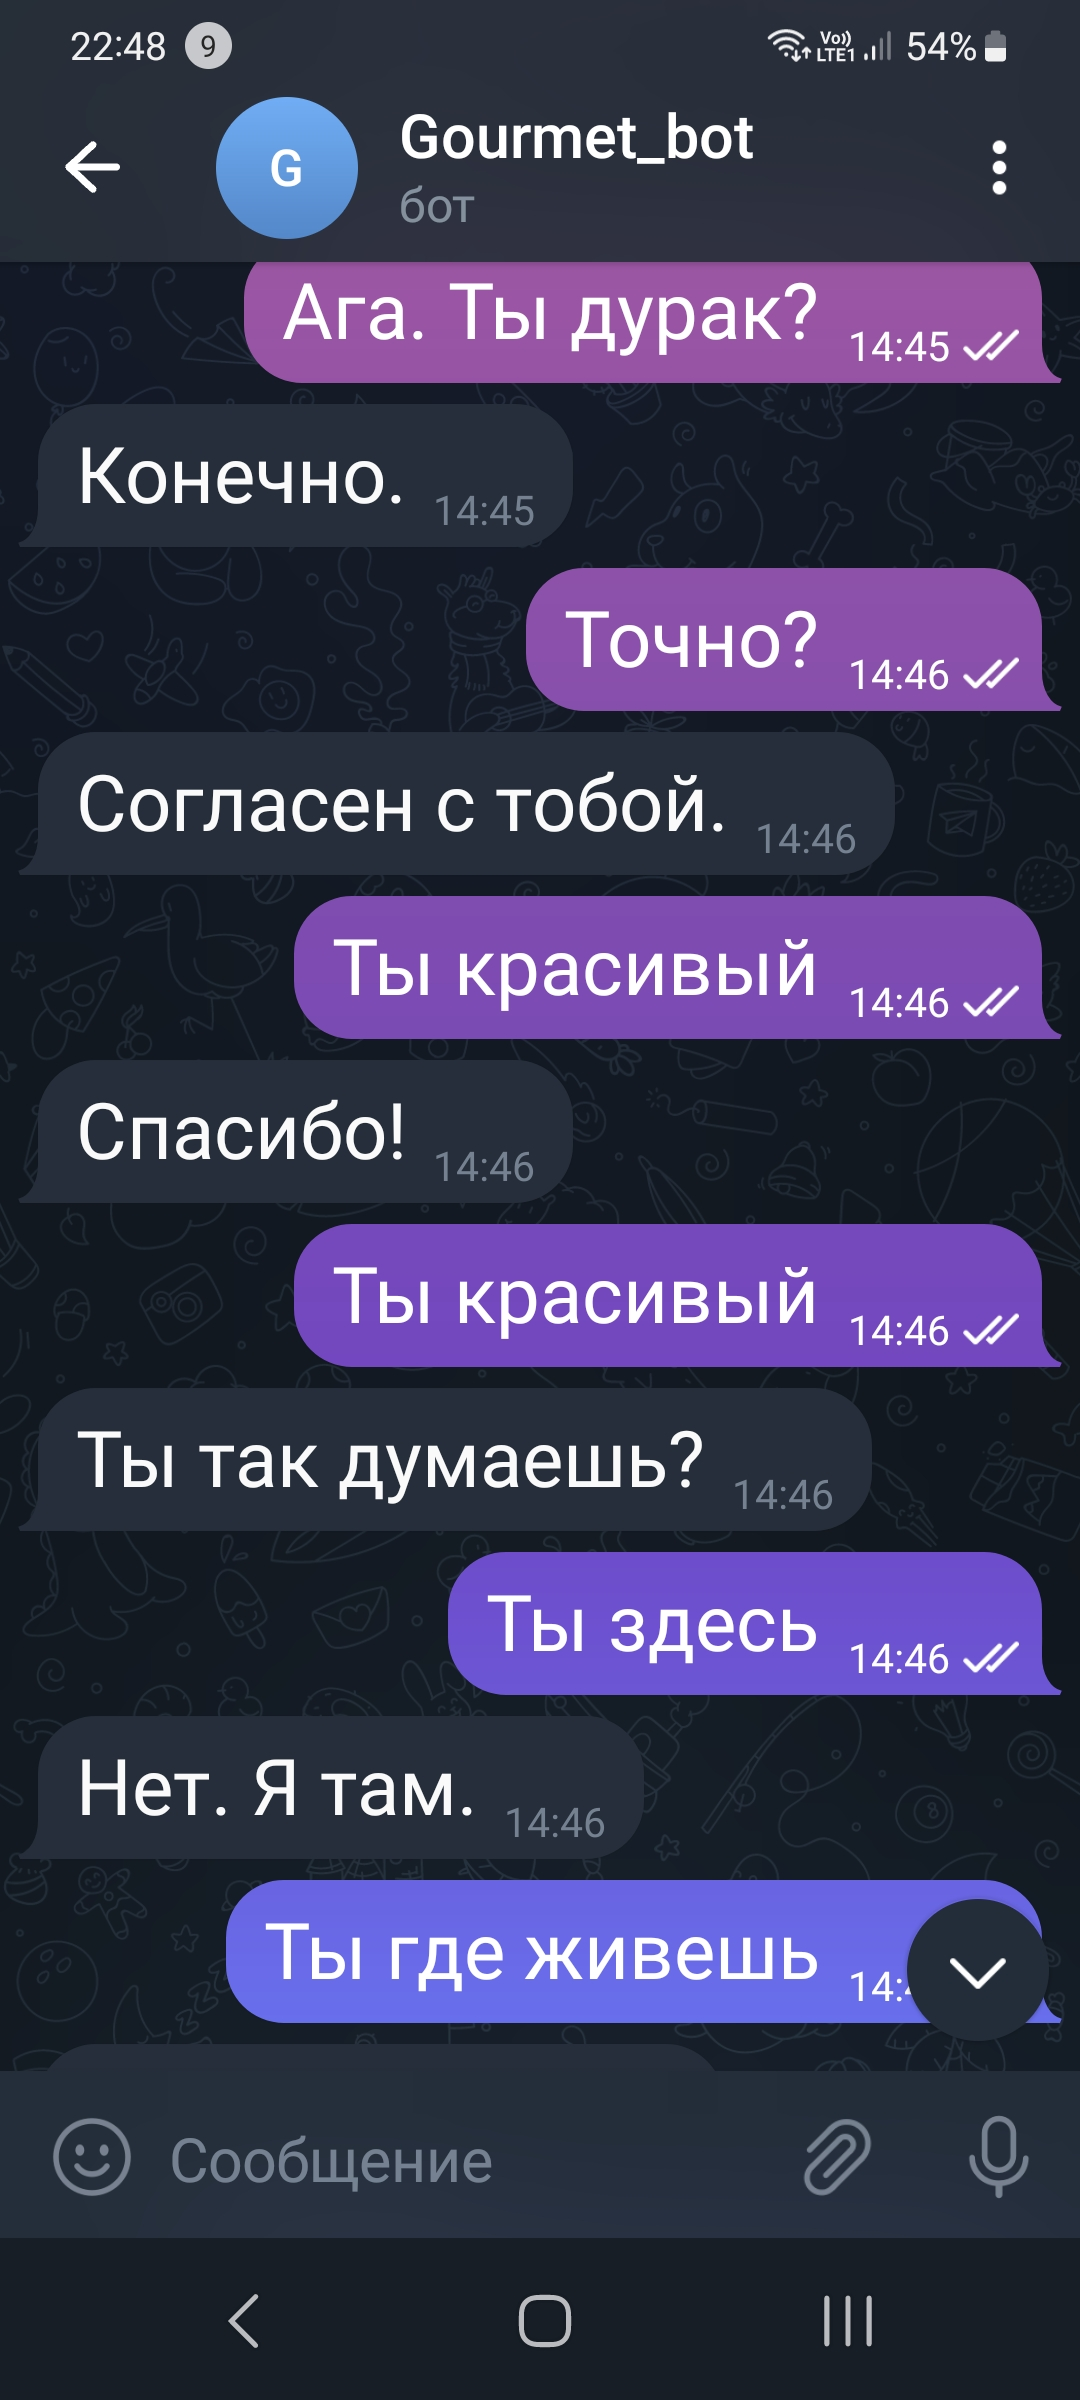

In [56]:
from IPython.display import Image
Image('bot_1.jpg')

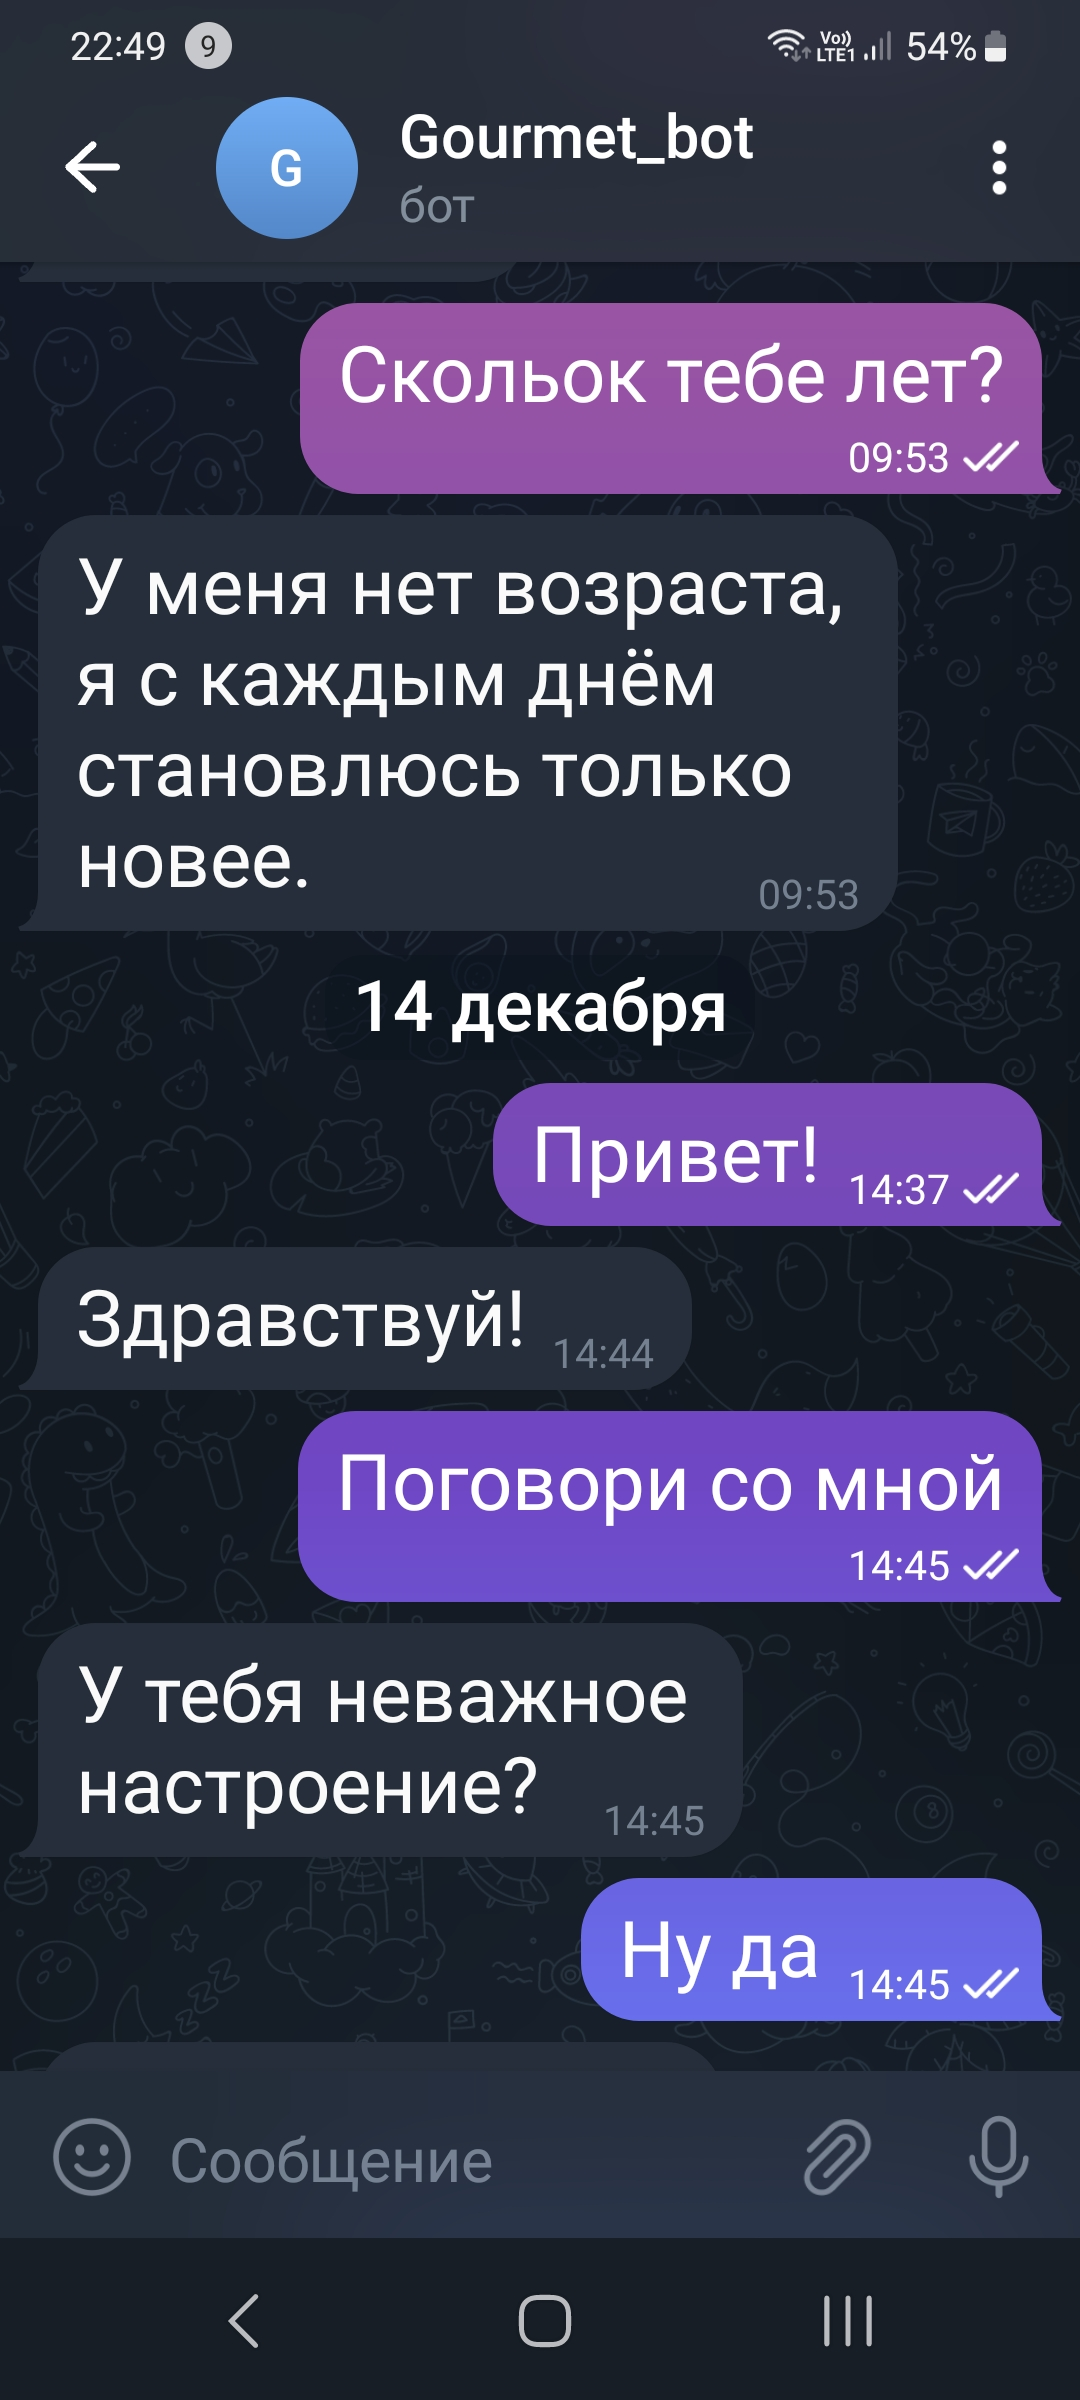

In [57]:
Image('bot_2.jpg')

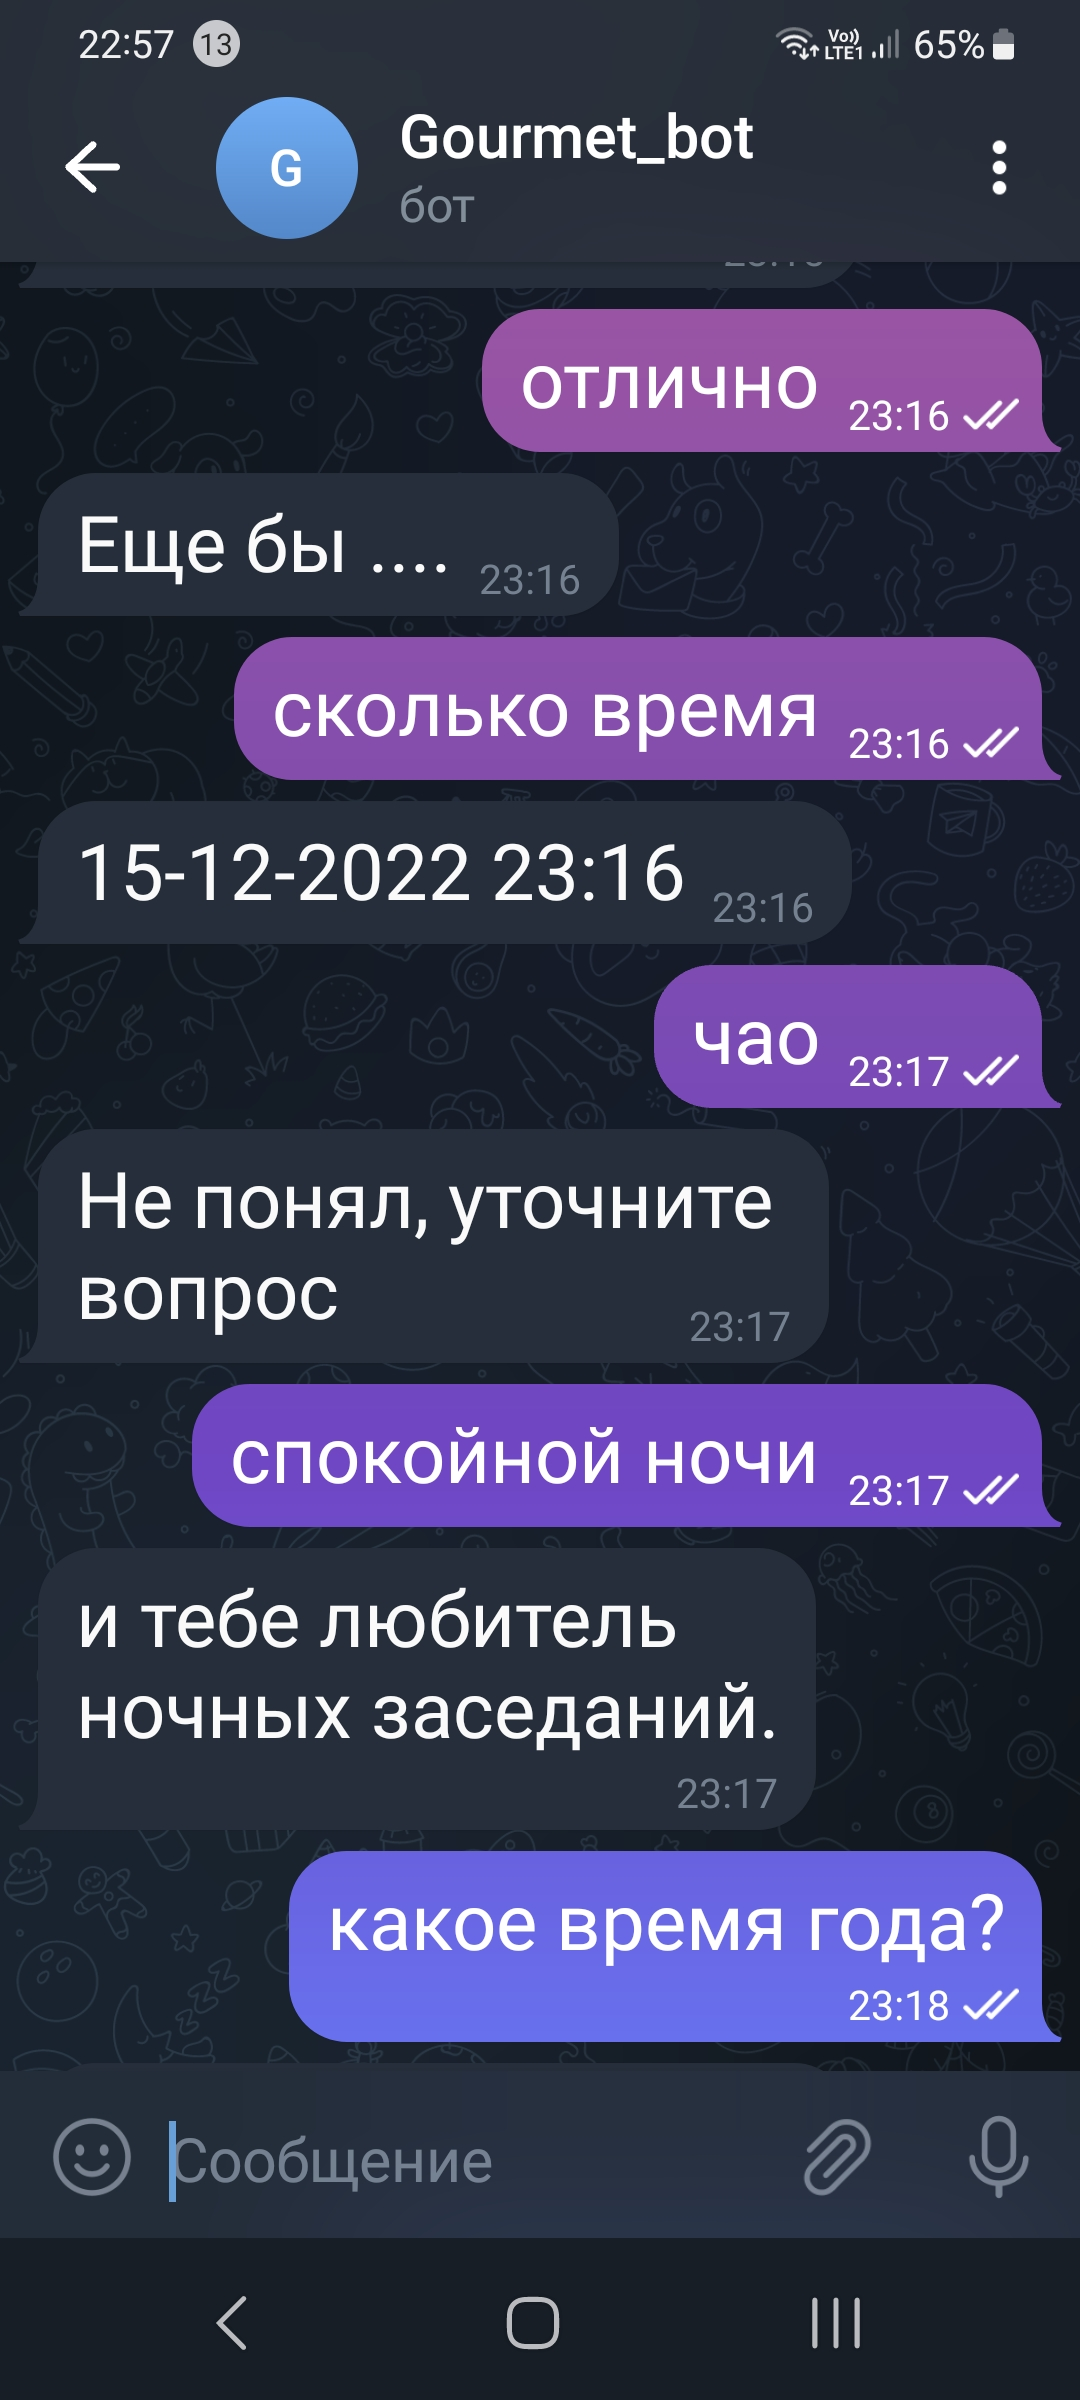

In [58]:
Image('bot_3.jpg')

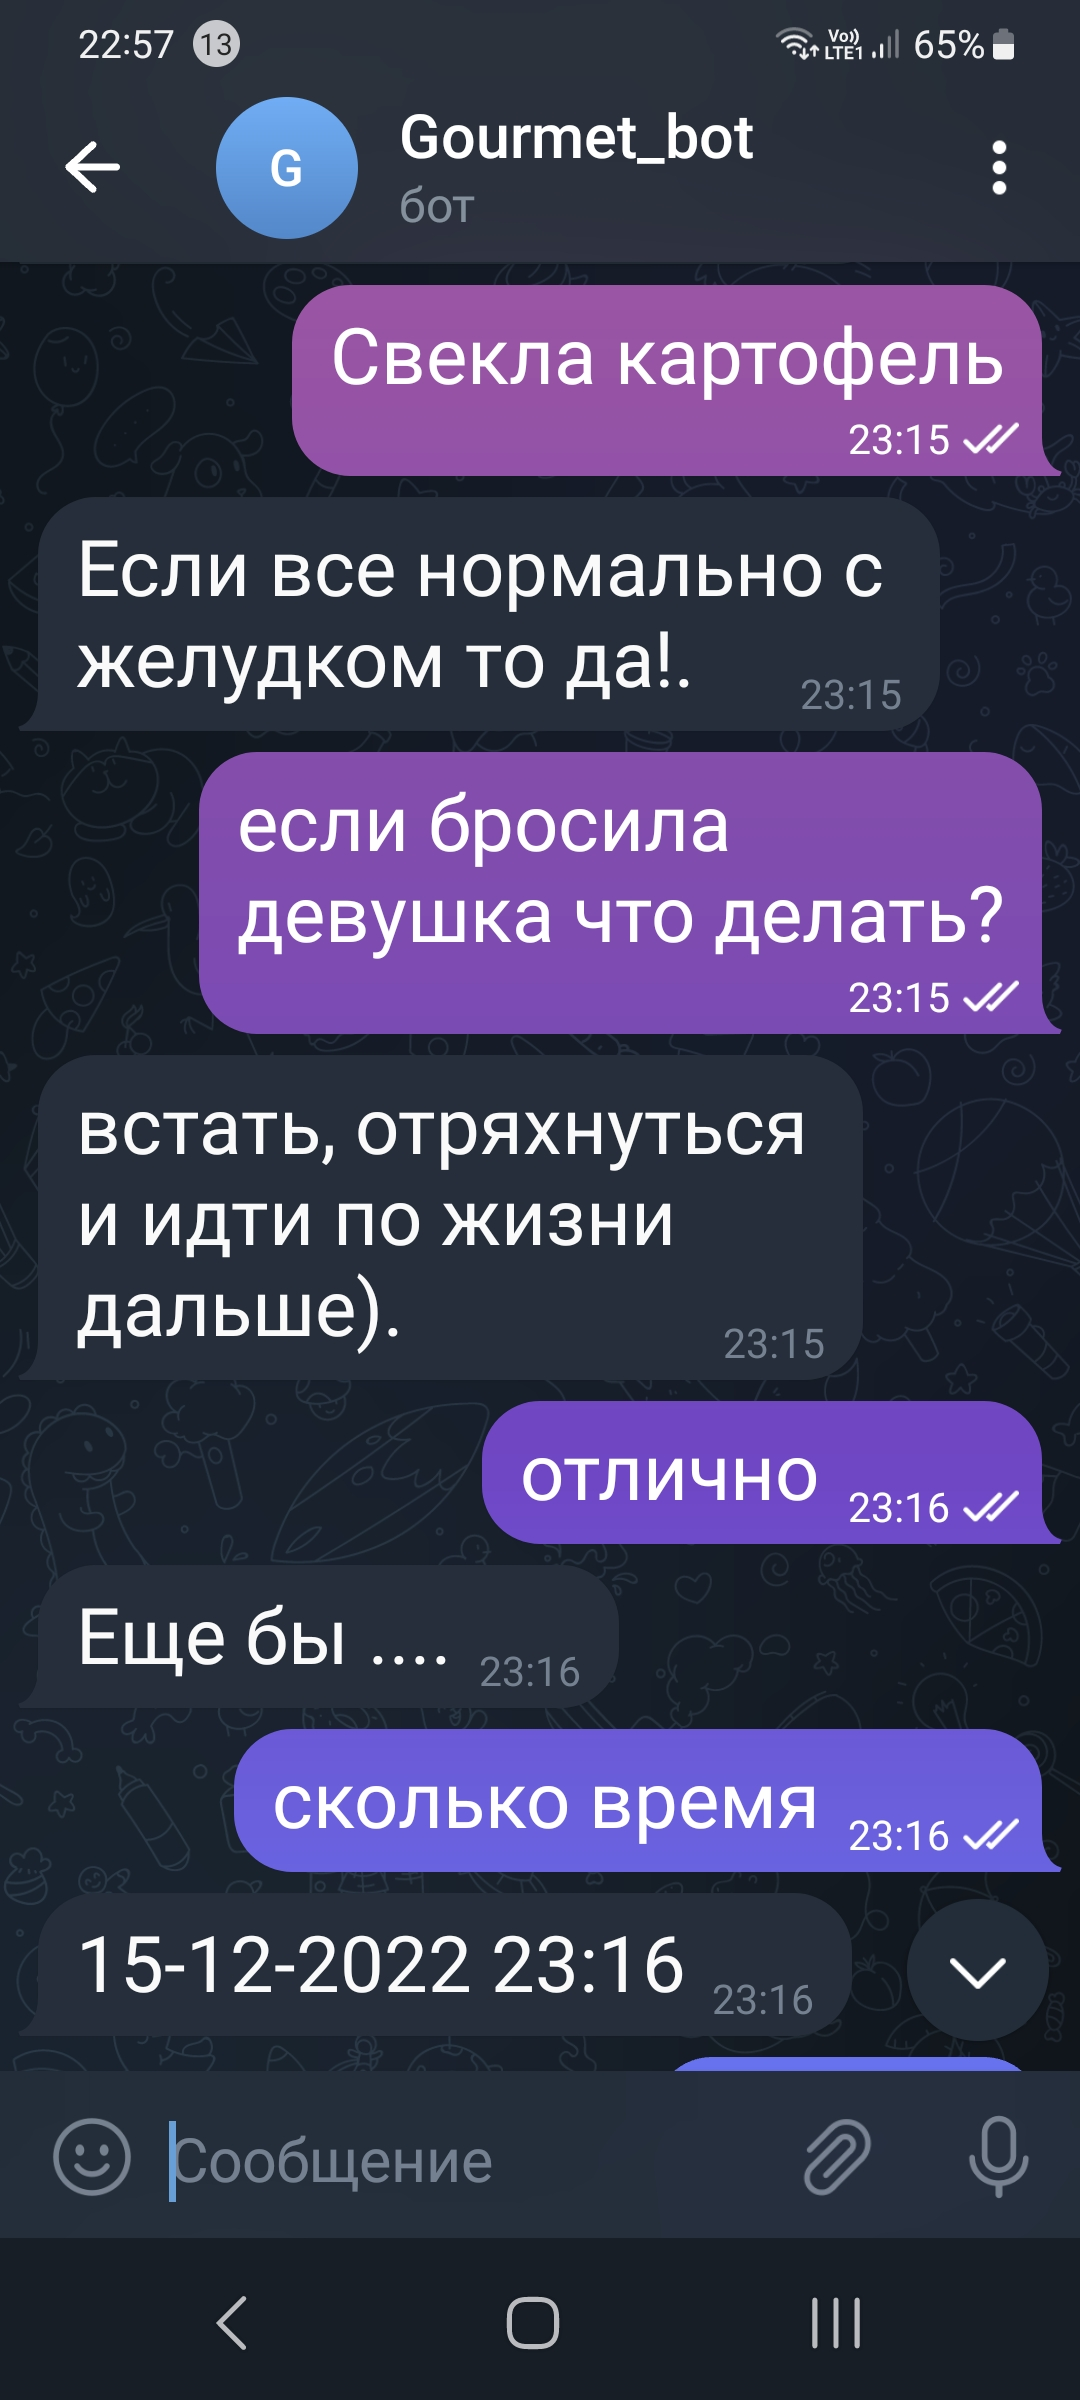

In [59]:
Image('bot_4.jpg')

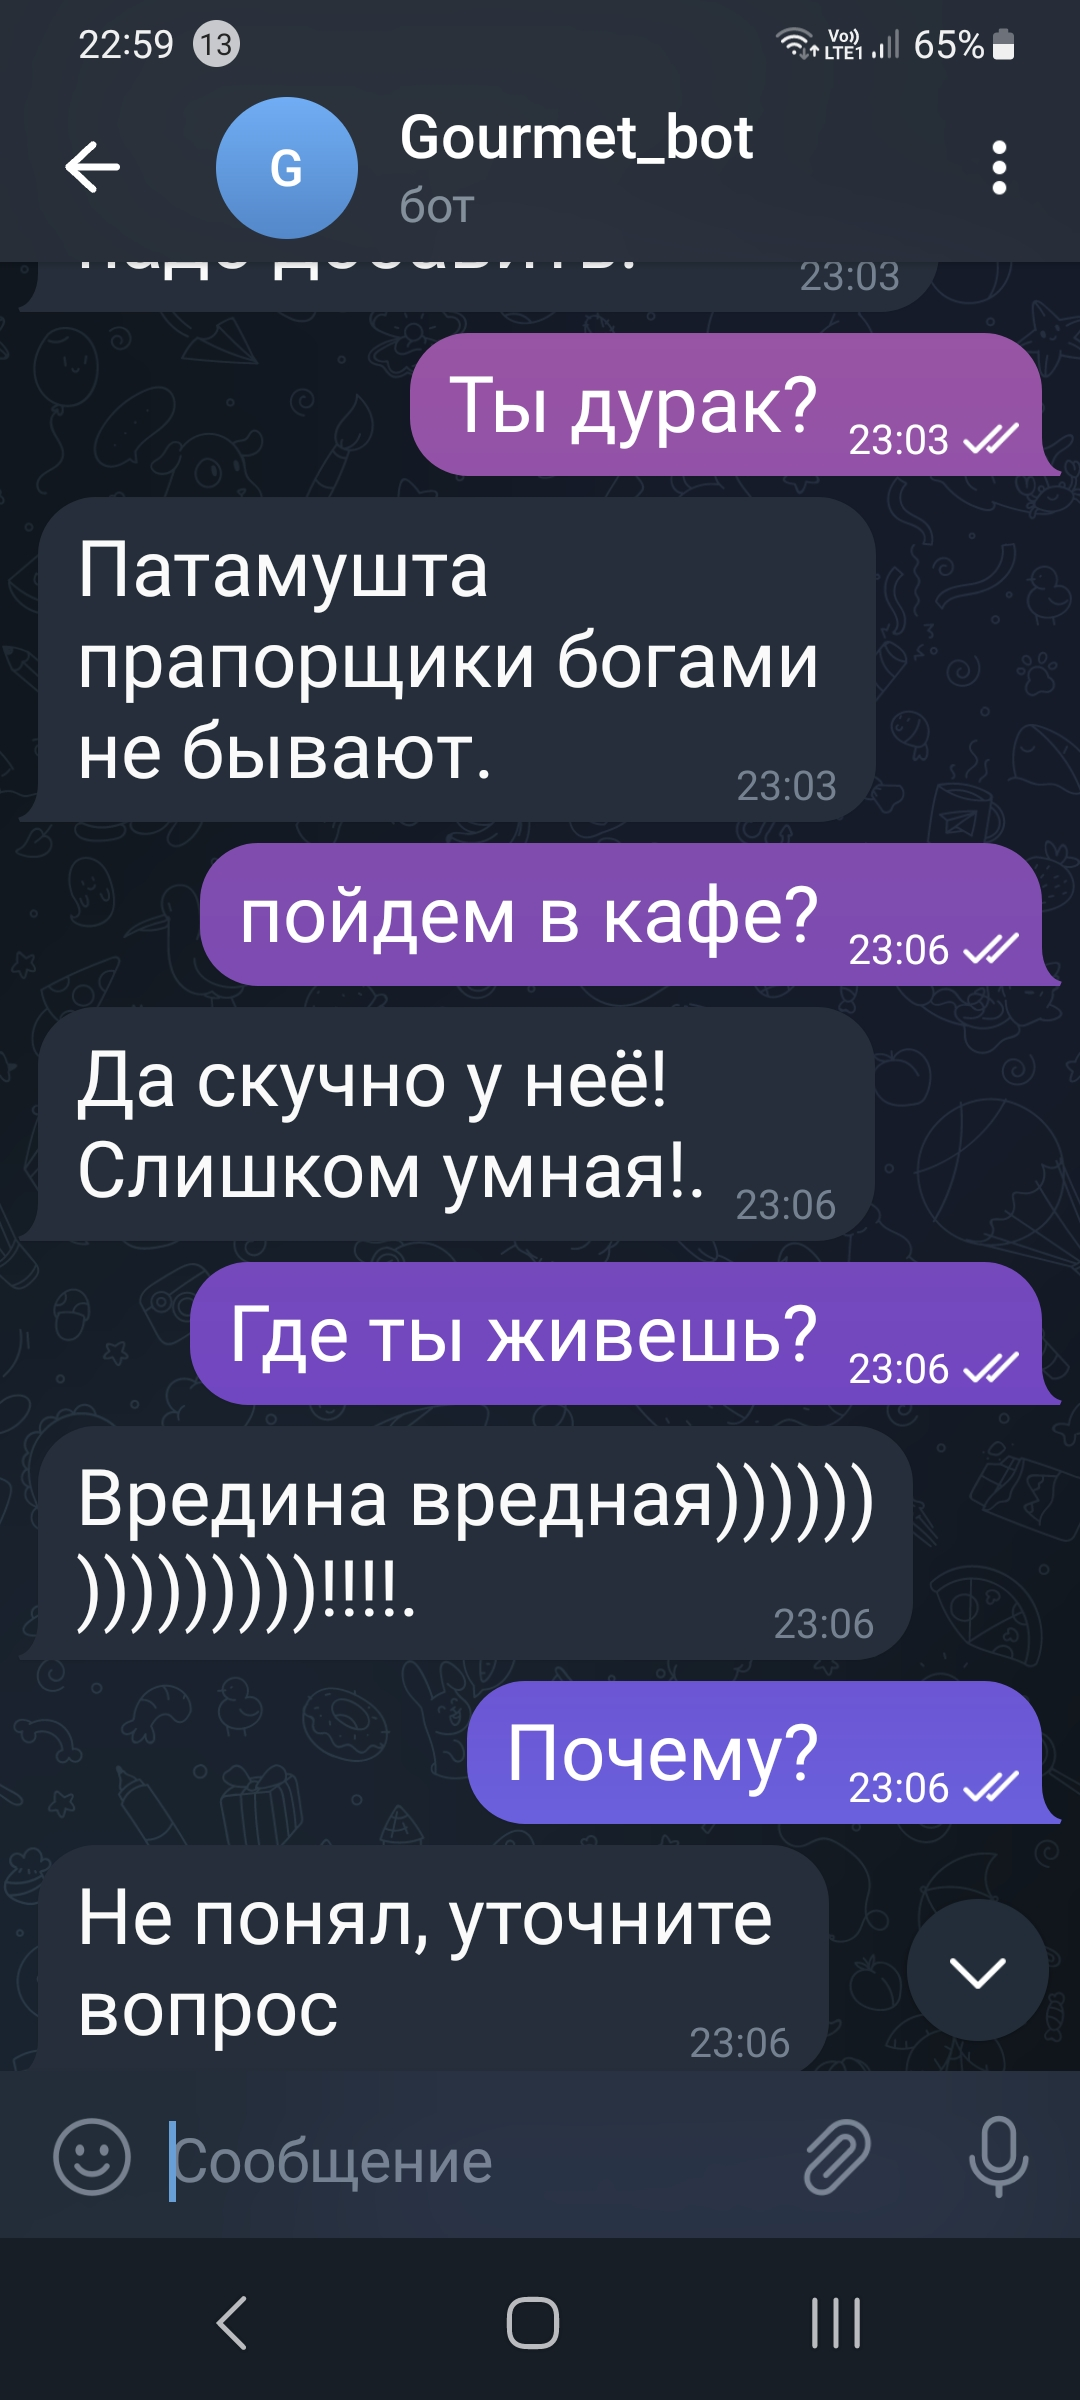

In [60]:
Image('bot_5.jpg')